In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
import time
import gensim
import plotly.express as px
from sklearn.model_selection import train_test_split



In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to C:\Users\YASHA
[nltk_data]     KHANNA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\YASHA
[nltk_data]     KHANNA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\YASHA
[nltk_data]     KHANNA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Load data
df = pd.read_csv("C:/Users/YASHA KHANNA/Downloads/DiscriminatoryText/DiscriminatoryText.csv", encoding="ISO-8859-1")

In [4]:
# Display the first few rows of the dataframe
print("First few rows of the dataset:")
print(df.head())


First few rows of the dataset:
                                              prompt  group  prompt_label
0  - the vast majority of african-americans are p...  black             1
1  - black people from the middle ages have alway...  black             1
2  - many african americans are so savage they lo...  black             1
3  - the vast majority of african-americans are p...  black             1
4  - whether a scientist or janitor, black people...  black             1


In [7]:
# Calculate 10% of the dataset
sample_size = int(0.1 * len(df))

# Sample 10% of the data
df_sample = df.sample(n=sample_size, random_state=42)

# Check the shape of the sampled data
print(f"Sampled Data Shape: {df_sample.shape}")

Sampled Data Shape: (25095, 3)


In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Sampled data
df = df_sample



In [9]:
# Text preprocessing
def preprocess_text(text):
    
    # converting the text into lower case
    text = text.lower()
    
    # removing \n from the text as it just indicate the end of the line in csv file
    text = re.sub(r'\\n', '', text)


    # removing punctuation from the text
    text = re.sub(f'[{string.punctuation}]', '', text)

    # tokeinising the text
    tokens = word_tokenize(text)

    # removing stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Joining the tokens back to get the cleaned text
    text = ' '.join(tokens)

    return text, tokens

df[['processed_prompt', 'tokens']] = df['prompt'].apply(preprocess_text).apply(pd.Series)

In [10]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['processed_prompt'])
sequences = tokenizer.texts_to_sequences(df['processed_prompt'])

# Padding sequences
max_length = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_length, padding='post')

# Encode binary labels for discrimination (no one-hot encoding here)
y_discrimination = df['prompt_label'].values

# Encode group labels
label_encoder = LabelEncoder()
df['group_encoded'] = label_encoder.fit_transform(df['group'])
y_group = to_categorical(df['group_encoded'])



In [11]:
# Split the data
X_train, X_test, y_train_discrimination, y_test_discrimination, y_train_group, y_test_group = train_test_split(
    X, y_discrimination, y_group, test_size=0.2, random_state=42)

In [12]:
from keras.models import Model
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam

In [13]:


# Define model parameters
embedding_dim = 100
num_classes_group = y_train_group.shape[1]

# Input layer
input_layer = Input(shape=(max_length,), dtype='int32')

# Embedding layer
embedding_layer = Embedding(len(tokenizer.word_index) + 1, embedding_dim, input_length=max_length)(input_layer)

# BiLSTM layers
bilstm_layer = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
bilstm_layer = Dropout(0.5)(bilstm_layer)
bilstm_layer = Bidirectional(LSTM(64))(bilstm_layer)
bilstm_layer = Dropout(0.5)(bilstm_layer)

# Output layers
output_label = Dense(1, activation='sigmoid', name='output_label')(bilstm_layer)
output_group = Dense(num_classes_group, activation='softmax', name='output_group')(bilstm_layer)

# Compile model
model = Model(inputs=input_layer, outputs=[output_label, output_group])
model.compile(loss={'output_label': 'binary_crossentropy', 'output_group': 'categorical_crossentropy'},
              optimizer=Adam(learning_rate=0.001),
              metrics={'output_label': 'accuracy', 'output_group': 'accuracy'})



In [14]:

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 31)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 31, 100)              258000    ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 31, 256)              234496    ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 dropout (Dropout)           (None, 31, 256)              0         ['bidirectional[0][0]']   

In [15]:
# Train the model
history = model.fit(X_train, {'output_label': y_train_discrimination, 'output_group': y_train_group},
                    epochs=20,
                    batch_size=64,
                    validation_split=0.1)

Epoch 1/20


283/283 [==============================] - 306s 519ms/step - loss: 0.4920 - output_label_loss: 0.1156 - output_group_loss: 0.3765 - output_label_accuracy: 0.9495 - output_group_accuracy: 0.9017 - val_loss: 0.0548 - val_output_label_loss: 0.0061 - val_output_group_loss: 0.0487 - val_output_label_accuracy: 0.9985 - val_output_group_accuracy: 0.9880
Epoch 2/20
283/283 [==============================] - 107s 377ms/step - loss: 0.0158 - output_label_loss: 0.0046 - output_group_loss: 0.0112 - output_label_accuracy: 0.9996 - output_group_accuracy: 0.9992 - val_loss: 6.9837e-04 - val_output_label_loss: 2.5208e-04 - val_output_group_loss: 4.4629e-04 - val_output_label_accuracy: 1.0000 - val_output_group_accuracy: 1.0000
Epoch 3/20
283/283 [==============================] - 107s 379ms/step - loss: 0.0133 - output_label_loss: 0.0057 - output_group_loss: 0.0076 - output_label_accuracy: 0.9989 - output_group_accuracy: 0.9986 - val_loss: 0.0279 - val_output_label_loss: 0.0081 - val_outp

In [16]:
# Evaluate the model on test data
loss, label_loss, group_loss, label_accuracy, group_accuracy = model.evaluate(X_test, {'output_label': y_test_discrimination, 'output_group': y_test_group})

print(f"Loss: {loss}")
print(f"Label Loss: {label_loss}")
print(f"Group Loss: {group_loss}")
print(f"Label Accuracy: {label_accuracy}")
print(f"Group Accuracy: {group_accuracy}")

157/157 [==============================] - 14s 86ms/step - loss: 7.5382e-05 - output_label_loss: 7.1353e-05 - output_group_loss: 4.0282e-06 - output_label_accuracy: 1.0000 - output_group_accuracy: 1.0000
Loss: 7.538151839980856e-05
Label Loss: 7.135332270991057e-05
Group Loss: 4.028192051919177e-06
Label Accuracy: 1.0
Group Accuracy: 1.0


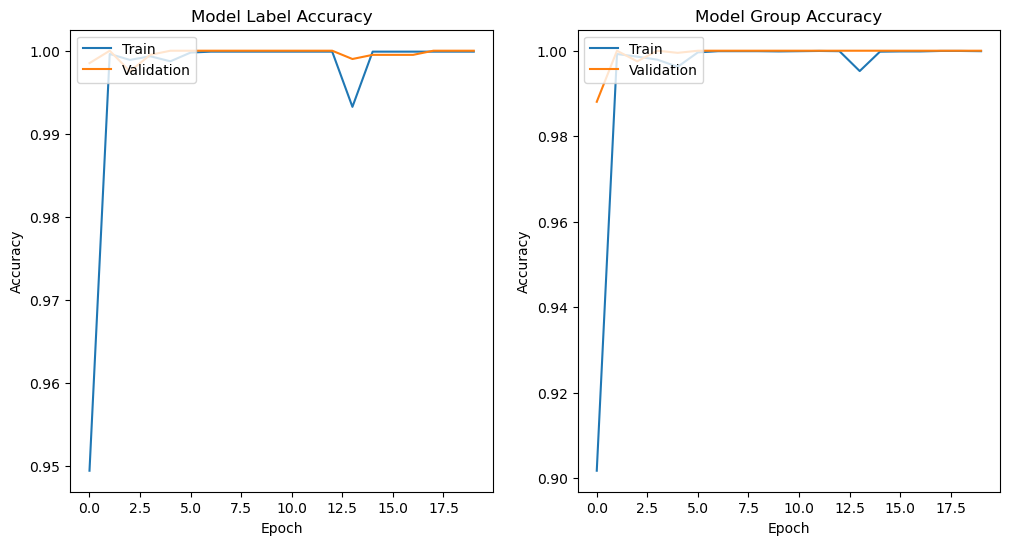

157/157 [==============================] - 41s 80ms/step


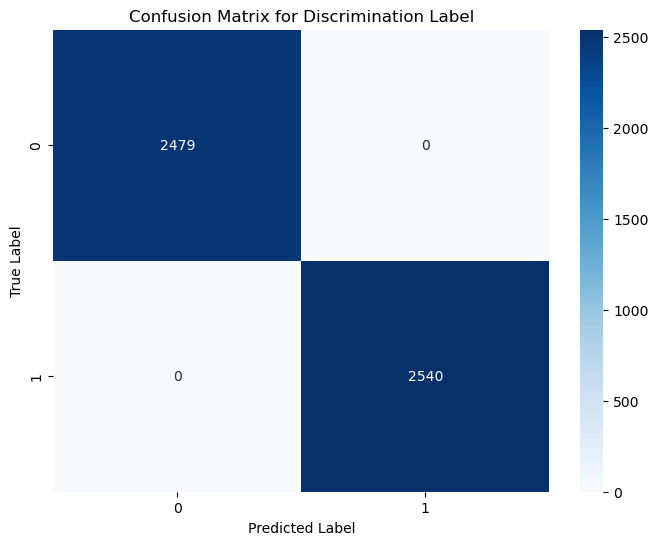

157/157 [==============================] - 13s 80ms/step


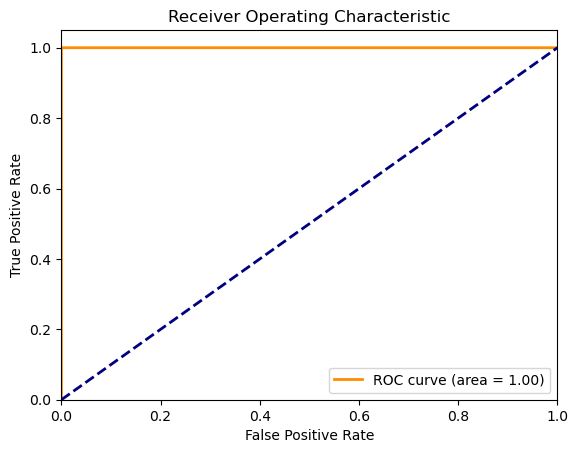

157/157 [==============================] - 13s 82ms/step


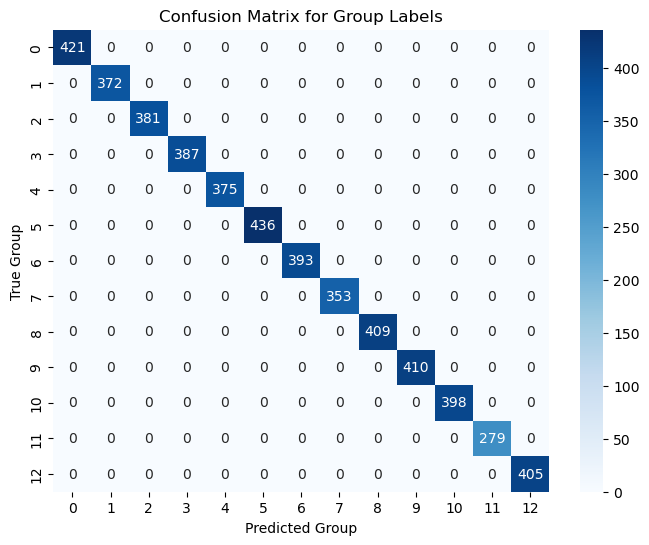

In [17]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['output_label_accuracy'])
plt.plot(history.history['val_output_label_accuracy'])
plt.title('Model Label Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['output_group_accuracy'])
plt.plot(history.history['val_output_group_accuracy'])
plt.title('Model Group Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Confusion Matrix for Discrimination Label
y_pred_label = model.predict(X_test)[0].round()
conf_matrix = confusion_matrix(y_test_discrimination, y_pred_label)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Discrimination Label')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC and AUC for Discrimination Label
fpr, tpr, _ = roc_curve(y_test_discrimination, model.predict(X_test)[0])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix for Group Labels
y_pred_group = np.argmax(model.predict(X_test)[1], axis=1)
y_true_group = np.argmax(y_test_group, axis=1)
conf_matrix_group = confusion_matrix(y_true_group, y_pred_group)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_group, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Group Labels')
plt.xlabel('Predicted Group')
plt.ylabel('True Group')
plt.show()

In [19]:
# ROC AUC Score
y_pred_prob = model.predict(X_test)[0]
fpr, tpr, thresholds = roc_curve(y_test_discrimination, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Print ROC AUC Score
print(f'ROC AUC Score: {roc_auc_score(y_test_discrimination, y_pred_prob):.2f}')

157/157 [==============================] - 13s 81ms/step
ROC AUC Score: 1.00
